In [4]:
%reload_ext autoreload
import sys
sys.path.append("../utils/")

# general imports
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

# AWS imports: Import Braket SDK modules

from braket.circuits import Circuit, Gate, Instruction, circuit, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice
import numpy as np
from numpy.linalg import eigh

import functools
import time

from utils import DeviceUtils,DeviceScanner,BraketTaskScanner,Plotter, qasm_source
from hadamard_bench import *
from IonQCompiler import IonQCompiler
from pyquil import get_qc
from quil_utils import *

import json
import pandas as pd
import seaborn as sns 
import networkx as nx

In [5]:
rigetti = DeviceUtils.get_device('rigetti')
ion_q = DeviceUtils.get_device('ionq')
# rigetti = LocalSimulator()
#ion_q = LocalSimulator()

ds = DeviceScanner( device=ion_q)

ds.get_cost_infos()

a:b:c:us-east-1


{'task': 0.3, 'shot': 0.01}

## Tomography


In [6]:
shots = 500
#set_n_qubits = range(3,10)
n_qubits = 11
set_line_length = [5,10,15,20]
print(set_line_length)

[5, 10, 15, 20]


Rigetti tasks


In [36]:
tomo_tasks = []
labels = []

#0 gates circuit
circ = Circuit().h(range(n_qubits)).h(range(n_qubits))
circ_x, circ_y, circ_z = tomography_circuits(circ, circ.qubits)
#print(circ_x, circ_y, circ_z)

task_x = rigetti.run(circ_x,shots=shots)
task_y = rigetti.run(circ_y,shots=shots)
task_z = rigetti.run(circ_z,shots=shots)

tomo_tasks.extend((task_x,task_y,task_z))
labels.append( "rigetti_tomo_x_" + str(0))
labels.append( "rigetti_tomo_y_" + str(0))
labels.append( "rigetti_tomo_z_" + str(0))

for line_length in set_line_length:
    print(line_length)
    
    circ = Circuit().H_line(n_qubits,line_length,'Rigetti')
    circ = Circuit().add_verbatim_box(circ)

    circ_x, circ_y, circ_z = tomography_circuits(circ, circ.qubits)

    #print(circ_x, circ_y, circ_z)
    
    task_x = rigetti.run(circ_x,shots=shots,disable_qubit_rewiring=True)
    task_y = rigetti.run(circ_y,shots=shots,disable_qubit_rewiring=True)
    task_z = rigetti.run(circ_z,shots=shots,disable_qubit_rewiring=True)
    tomo_tasks.extend((task_x,task_y,task_z))
    labels.append( "rigetti_tomo_x_" + str(line_length))
    labels.append( "rigetti_tomo_y_" + str(line_length))
    labels.append( "rigetti_tomo_z_" + str(line_length))

5
10
15
20
25


In [38]:
print(tomo_tasks)
print(labels)

dump_tasks(tomo_tasks, labels, filename = "H_line_tomography")

[AwsQuantumTask('id/taskArn':'arn:aws:braket:us-west-1:058017682654:quantum-task/bb963bb1-d540-4361-b986-addb4bb70fee'), AwsQuantumTask('id/taskArn':'arn:aws:braket:us-west-1:058017682654:quantum-task/f92c51ef-c65a-42d4-933e-e93baeb2f5ec'), AwsQuantumTask('id/taskArn':'arn:aws:braket:us-west-1:058017682654:quantum-task/9f4b0f11-41ea-4cb3-bf14-0782632bcb25'), AwsQuantumTask('id/taskArn':'arn:aws:braket:us-west-1:058017682654:quantum-task/7263dcb0-5139-4a8b-8418-7fc7cf9f2dc6'), AwsQuantumTask('id/taskArn':'arn:aws:braket:us-west-1:058017682654:quantum-task/de4a14d3-5ce3-4bda-9efb-500b3ab27fe0'), AwsQuantumTask('id/taskArn':'arn:aws:braket:us-west-1:058017682654:quantum-task/b3f1246f-65a0-42ab-aaa6-932f58c94bbe'), AwsQuantumTask('id/taskArn':'arn:aws:braket:us-west-1:058017682654:quantum-task/6737b965-6b0e-4db5-9983-142a81be058b'), AwsQuantumTask('id/taskArn':'arn:aws:braket:us-west-1:058017682654:quantum-task/956563ed-9ed1-4f80-82e9-67679671419f'), AwsQuantumTask('id/taskArn':'arn:aws:br

Ionq Tasks

In [26]:
tomo_tasks = []
labels = []

#0 gates circuit
circ = Circuit().h(range(n_qubits)).h(range(n_qubits))
circ_x, circ_y, circ_z = tomography_circuits(circ, circ.qubits)
#print(circ_x, circ_y, circ_z)

task_x = ion_q.run(circ_x,shots=shots)
task_y = ion_q.run(circ_y,shots=shots)
task_z = ion_q.run(circ_z,shots=shots)

tomo_tasks.extend((task_x,task_y,task_z))
labels.append( "ionq_tomo_x_" + str(0))
labels.append( "ionq_tomo_y_" + str(0))
labels.append( "ionq_tomo_z_" + str(0))

iqc = IonQCompiler()

for line_length in set_line_length:
    print(line_length)
    
    native_h = Circuit().h(range(n_qubits))
    native_h =  iqc.compile(native_h)

    h_circ = Circuit()
    for i in range(line_length):
        h_circ.add(native_h)
        

    circ_x, circ_y, circ_z = tomography_circuits(Circuit(), h_circ.qubits)

    temp_x = deepcopy(h_circ)
    circ_x = temp_x.add(iqc.compile(circ_x))
    circ_x = Circuit().add_verbatim_box(circ_x)
    temp_y = deepcopy(h_circ)
    circ_y = temp_y.add(iqc.compile(circ_y))
    circ_y = Circuit().add_verbatim_box(circ_y)
    temp_z = deepcopy(h_circ)
    circ_z = temp_z
    circ_z = Circuit().add_verbatim_box(circ_z)
    
    # print("x",circ_x)
    # print("y",circ_y)
    # print("z",circ_z)
    
    task_x = ion_q.run(circ_x,shots=shots,disable_qubit_rewiring=True)
    task_y = ion_q.run(circ_y,shots=shots,disable_qubit_rewiring=True)
    task_z = ion_q.run(circ_z,shots=shots,disable_qubit_rewiring=True)
    tomo_tasks.extend((task_x,task_y,task_z))
    labels.append( "ionq_tomo_x_" + str(line_length))
    labels.append( "ionq_tomo_y_" + str(line_length))
    labels.append( "ionq_tomo_z_" + str(line_length))

5
10
15
20


In [27]:
print(tomo_tasks)
print(labels)

dump_tasks(tomo_tasks, labels, filename = "H_line_tomography_ionq")

[AwsQuantumTask('id/taskArn':'arn:aws:braket:us-east-1:058017682654:quantum-task/30c10f72-0b72-494e-87d3-f30fbb5dce50'), AwsQuantumTask('id/taskArn':'arn:aws:braket:us-east-1:058017682654:quantum-task/a074fc78-63be-4fa5-b107-0f9c46a5cc6f'), AwsQuantumTask('id/taskArn':'arn:aws:braket:us-east-1:058017682654:quantum-task/a2587129-0344-4b72-985f-433427835db7'), AwsQuantumTask('id/taskArn':'arn:aws:braket:us-east-1:058017682654:quantum-task/8d34ca8f-1f36-4122-9b3b-336fa5b0036c'), AwsQuantumTask('id/taskArn':'arn:aws:braket:us-east-1:058017682654:quantum-task/4bfbdb7a-197e-4d77-8566-e506bc810886'), AwsQuantumTask('id/taskArn':'arn:aws:braket:us-east-1:058017682654:quantum-task/b6c0c759-4408-40a6-b548-7571f5646bbb'), AwsQuantumTask('id/taskArn':'arn:aws:braket:us-east-1:058017682654:quantum-task/db3e1e04-7141-4063-a4c1-c0efc034fc00'), AwsQuantumTask('id/taskArn':'arn:aws:braket:us-east-1:058017682654:quantum-task/97822161-80e0-4c77-b52e-38f8299451a6'), AwsQuantumTask('id/taskArn':'arn:aws:br

## Task retrival


In [3]:
tasks = load_tasks("H_line_tomography")
scanners = [BraketTaskScanner(qtask = task) for key, task in tasks.items()]

status = [task.get_status() for task in scanners]
cost = [task.cost_extimate() for task in scanners]
print(status, cost)

['COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED'] [Decimal('0.6500000000'), Decimal('0.6500000000'), Decimal('0.6500000000'), Decimal('0.6500000000'), Decimal('0.6500000000'), Decimal('0.6500000000'), Decimal('0.6500000000'), Decimal('0.6500000000'), Decimal('0.6500000000'), Decimal('0.6500000000'), Decimal('0.6500000000'), Decimal('0.6500000000'), Decimal('0.6500000000'), Decimal('0.6500000000'), Decimal('0.6500000000'), Decimal('0.6500000000'), Decimal('0.6500000000'), Decimal('0.6500000000')]


In [29]:
from typing import List

def get_tomography_results( scanners: List[BraketTaskScanner]):

    n_qubits = [sc.get_results().measured_qubits for sc in scanners]

    per_qubits = [result_per_qubit(sc.get_results()) for sc in scanners]
    maps = [get_rigetti_rewiring_map(sc.get_compiled_circuit()) for sc in scanners]
    
    print(n_qubits)
    #print(scanners[0].get_compiled_circuit())
    #print(per_qubits[0])
    #print(map)
    #aggiungere mappa
    density = dict()
    purity = dict()
    for qubit in range(len(n_qubits[0])) :
        counts_x = np.array(per_qubits[0][per_qubits[0].qubit_n == qubit]["counts"])
        counts_y = np.array(per_qubits[1][per_qubits[1].qubit_n == qubit]["counts"])
        counts_z = np.array(per_qubits[2][per_qubits[2].qubit_n == qubit]["counts"])
        #print(counts)

        print(counts_x)
        x =  (counts_x[1]-counts_x[0])/(counts_x[1]+counts_x[0])
        y =  (counts_y[1]-counts_y[0])/(counts_y[1]+counts_y[0])
        z =  (counts_z[1]-counts_z[0])/(counts_z[1]+counts_z[0])

        r = x**2 + y**2 +z**2
        purity[maps[0][qubit]] = (1+r)/2
        x = x/r
        y = y/r
        z = z/r

        dmat = np.array([[1-z, x+ 1j*y],[x-1j*y, 1+z]], dtype=complex)
        density[maps[0][qubit]] = dmat

    return density,purity

density = []
purity = []
labels = [] 
for i in range(6):
    d, p = get_tomography_results( scanners[3*i:(3*(i+1))])
    labels.append("Rigetti Tomography H_line {}".format(5*i))

    density.append(d)
    purity.append(p)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]
[524 476]
[476 524]
[465 535]
[466 534]
[484 516]
[486 514]
[446 554]
[456 544]
[489 511]
[531 469]
[553 447]
[[40, 41, 42, 43, 140, 141, 142, 143, 144, 146, 147], [40, 41, 42, 43, 140, 141, 142, 143, 144, 146, 147], [40, 41, 42, 43, 140, 141, 142, 143, 144, 146, 147]]
[746 254]
[981  19]
[949  51]
[987  13]
[536 464]
[964  36]
[929  71]
[648 352]
[935  65]
[983  17]
[955  45]
[[40, 41, 42, 43, 140, 141, 142, 143, 144, 146, 147], [40, 41, 42, 43, 140, 141, 142, 143, 144, 146, 147], [40, 41, 42, 43, 140, 141, 142, 143, 144, 146, 147]]
[417 583]
[493 507]
[617 383]
[469 531]
[561 439]
[427 573]
[517 483]
[764 236]
[553 447]
[525 475]
[236 764]
[[40, 41, 42, 43, 140, 141, 142, 143, 144, 146, 147], [40, 41, 42, 43, 140, 141, 142, 143, 144, 146, 147], [40, 41, 42, 43, 140, 141, 142, 143, 144, 146, 147]]
[644 356]
[927  73]
[947  53]
[983  17]
[668 332]
[981  19]
[992   8]
[458 542]
[

In [30]:
import qutip
from mpl_toolkits.mplot3d import Axes3D
%pylab inline

def plot_on_device(data, device : AwsDevice, rewiring_map = None, ax= None, cmap = "RdYlGn_r"):

    if ax == None:
        fig, ax = plt.subplots(1,1, figsize = (5,6))

    if rewiring_map == None:
        rewiring_map = {x:x for x in range(len(data))}

    graph = device.topology_graph
    print(rewiring_map)
    col_vec = [ data.get(rewiring_map.get(x,-1),0) for x in range(len(graph.nodes))]
    nx.draw_kamada_kawai(graph, with_labels=True, node_color=col_vec, node_size=300, cmap=cmap, vmin = 0, vmax = 1, ax = ax)


    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = 0, vmax=1))
    plt.colorbar(sm, cax=cax, orientation='vertical')

def plot_density_eigen( densities, fig = None, ax = None, mayavi = False):

    n_mat = len(densities)
    major = np.empty((3, n_mat))
    minor = np.empty((3, n_mat))


    for i , key in enumerate(densities):

        values, vectors = eigh(densities[key])

        mi = vectors[:,0]
        mj = vectors[:,1]

        minor[:,i] =( (np.abs(mi[1])**2-np.abs(mi[0])**2), 2* np.real( mi[0]*np.conj(mi[1])),2* np.imag( mi[0]*np.conj(mi[1])))
        major[:,i] =( (np.abs(mj[1])**2-np.abs(mj[0])**2), 2* np.real( mj[0]*np.conj(mj[1])),2* np.imag( mj[0]*np.conj(mj[1])))

    if mayavi :
        b=qutip.Bloch3d()
    else:
        if ax == None:
            fig = plt.figure(figsize= (6,6))
            ax = Axes3D(fig, azim=-40, elev=30)

        b = qutip.Bloch(axes=ax)
    b.add_points([minor[1], minor[2], minor[0]])
    b.add_points([major[1], major[2], major[0]])
    #b.make_sphere()
    b.show()

    return ax
    

#plot_on_device( data = purity, device =DeviceUtils.get_device("ionq"))
#plot_density_eigen(density)


Populating the interactive namespace from numpy and matplotlib


{46: 0.935466, 13: 0.97161, 17: 0.9657, 43: 0.982866, 37: 0.705384, 101: 0.9598519999999999, 121: 0.762888, 40: 0.933648, 147: 0.992274, 27: 0.9724219999999999, 21: 0.6278900000000001}
{0: 46, 1: 13, 2: 17, 3: 43, 4: 37, 5: 101, 6: 121, 7: 40, 8: 147, 9: 27, 10: 21}
{0: 46, 1: 13, 2: 17, 3: 43, 4: 37, 5: 101, 6: 121, 7: 40, 8: 147, 9: 27, 10: 21}
{0: 40, 1: 41, 2: 42, 3: 43, 4: 140, 5: 141, 6: 142, 7: 143, 8: 144, 9: 146, 10: 147}
{0: 40, 1: 41, 2: 42, 3: 43, 4: 140, 5: 141, 6: 142, 7: 143, 8: 144, 9: 146, 10: 147}
{0: 40, 1: 41, 2: 42, 3: 43, 4: 140, 5: 141, 6: 142, 7: 143, 8: 144, 9: 146, 10: 147}
{0: 40, 1: 41, 2: 42, 3: 43, 4: 140, 5: 141, 6: 142, 7: 143, 8: 144, 9: 146, 10: 147}
{0: 40, 1: 41, 2: 42, 3: 43, 4: 140, 5: 141, 6: 142, 7: 143, 8: 144, 9: 146, 10: 147}
{0: 40, 1: 41, 2: 42, 3: 43, 4: 140, 5: 141, 6: 142, 7: 143, 8: 144, 9: 146, 10: 147}
{0: 40, 1: 41, 2: 42, 3: 43, 4: 140, 5: 141, 6: 142, 7: 143, 8: 144, 9: 146, 10: 147}
{0: 40, 1: 41, 2: 42, 3: 43, 4: 140, 5: 141, 6: 1

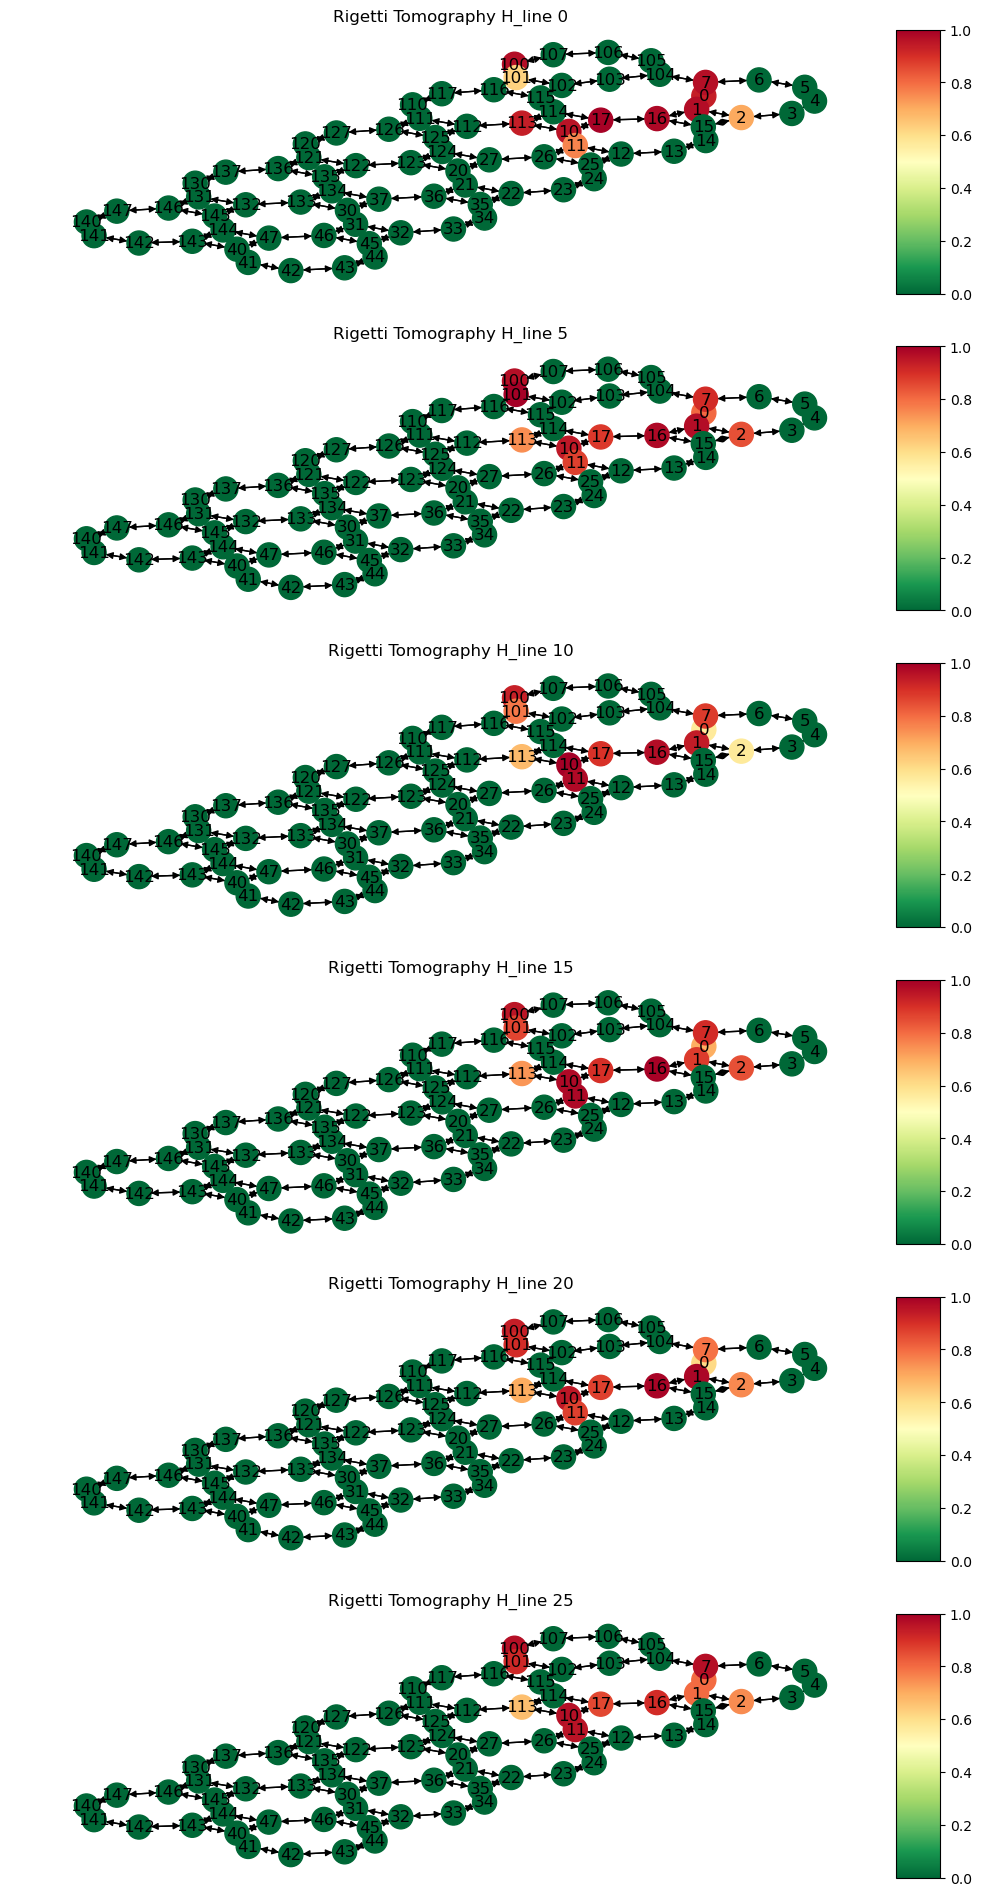

In [17]:
print(purity[0])

fig ,axx = plt.subplots(6,1, figsize = (12,24))

for ax ,p, lab in zip(axx, purity,labels):

    map = dict()
    for x, key in enumerate(p.keys()):
        map[x] = key

    print (map)

    plot_on_device( data = p, device =DeviceUtils.get_device("rigetti"),ax = ax, rewiring_map= map)
    ax.set_title(lab)

Visualize the pairs of eigenvetors of each density matrix on the bloch sphere

In [40]:
#requires mayavi and qutip

#choose the density dataset changing the index [.]
plot_density_eigen(densities=density[0], mayavi = True)

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

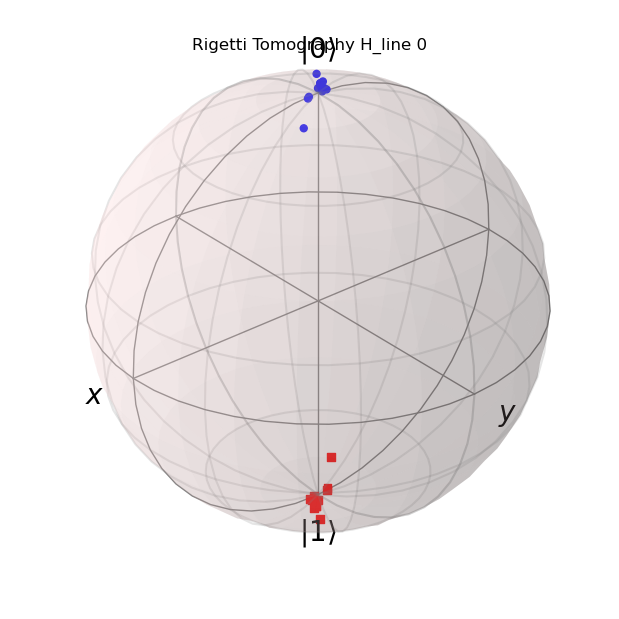

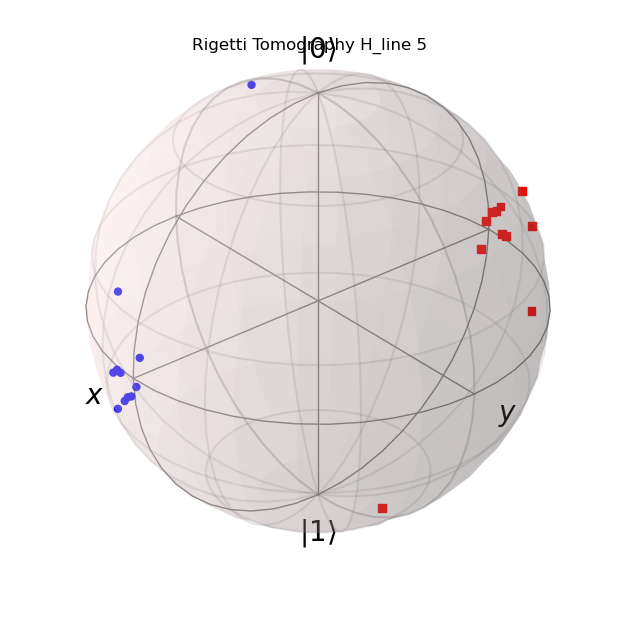

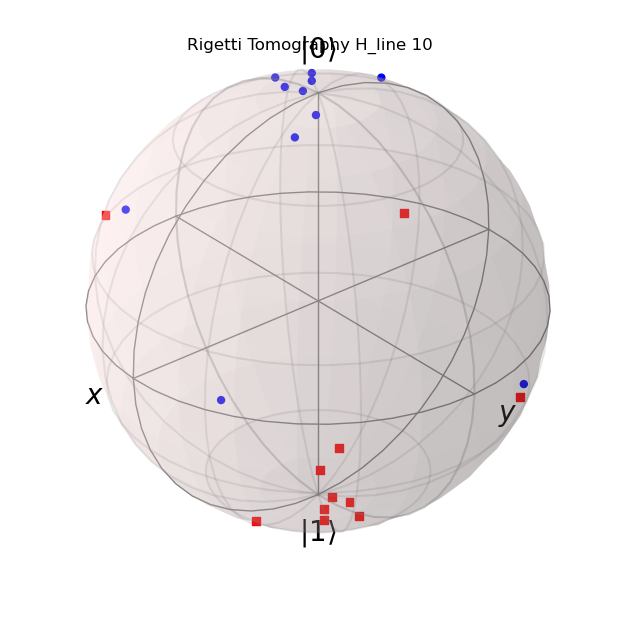

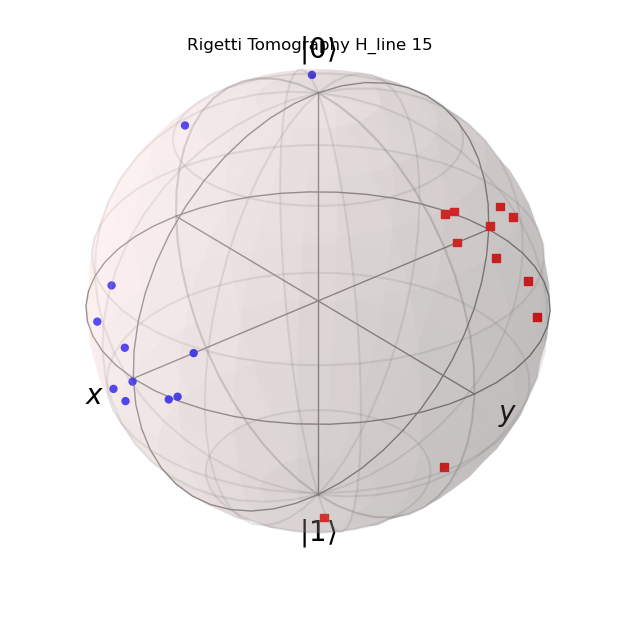

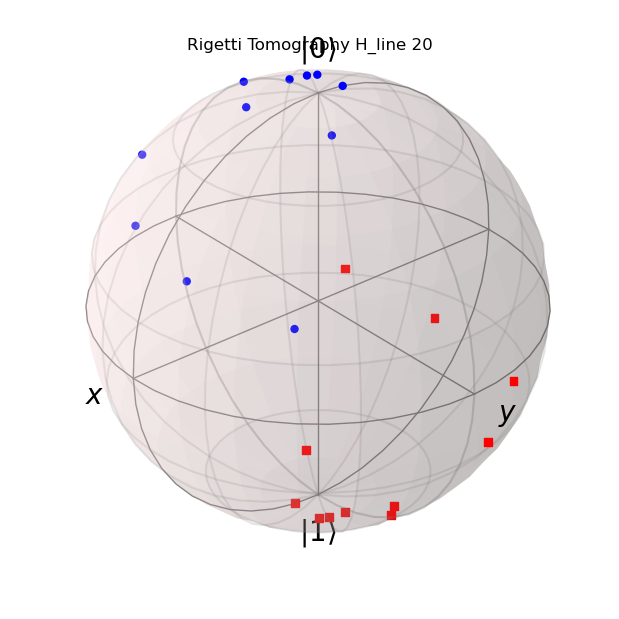

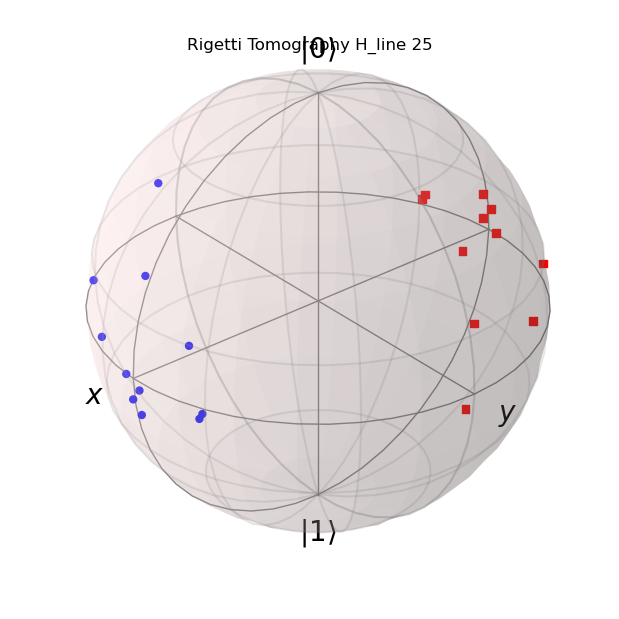

In [39]:
for ax,d, lab in zip(axx, density, labels):

    ax = plot_density_eigen(densities = d, mayavi = False)
    ax.set_title(lab)

IONQ results

-taks retrival


In [32]:
tasks = load_tasks("H_line_tomography_ionq")
scanners = [BraketTaskScanner(qtask = task) for key, task in tasks.items()]

status = [task.get_status() for task in scanners]
cost = [task.cost_extimate() for task in scanners]
print(status)

print (np.array(cost).sum())

['COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED']
79.5000000000


In [33]:
from typing import List

def get_tomography_results( scanners: List[BraketTaskScanner]):

    n_qubits = [sc.get_results().measured_qubits for sc in scanners]

    per_qubits = [result_per_qubit(sc.get_results()) for sc in scanners]

    
    print(n_qubits)
    #print(scanners[0].get_compiled_circuit())
    #print(per_qubits[0])
    #print(map)
    #aggiungere mappa
    density = dict()
    purity = dict()
    for qubit in range(len(n_qubits[0])) :
        counts_x = np.array(per_qubits[0][per_qubits[0].qubit_n == qubit]["counts"])
        counts_y = np.array(per_qubits[1][per_qubits[1].qubit_n == qubit]["counts"])
        counts_z = np.array(per_qubits[2][per_qubits[2].qubit_n == qubit]["counts"])
        #print(counts)

        print(counts_x)
        x =  (counts_x[1]-counts_x[0])/(counts_x[1]+counts_x[0])
        y =  (counts_y[1]-counts_y[0])/(counts_y[1]+counts_y[0])
        z =  (counts_z[1]-counts_z[0])/(counts_z[1]+counts_z[0])

        r = x**2 + y**2 +z**2
        purity[qubit] = (1+r)/2
        x = x/r
        y = y/r
        z = z/r

        dmat = np.array([[1-z, x+ 1j*y],[x-1j*y, 1+z]], dtype=complex)
        density[qubit] = dmat

    return density,purity

density = []
purity = []
labels = [] 
for i in range(5):
    d, p = get_tomography_results( scanners[3*i:(3*(i+1))])
    labels.append("Ionq Tomography H_line {}".format(5*i))

    density.append(d)
    purity.append(p)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]
[272 228]
[268 232]
[261 239]
[261 239]
[248 252]
[264 236]
[239 261]
[249 251]
[276 224]
[239 261]
[256 244]
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]
[493   7]
[497   3]
[493   7]
[492   8]
[492   8]
[488  12]
[493   7]
[495   5]
[493   7]
[495   5]
[493   7]
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]
[264 236]
[294 206]
[264 236]
[220 280]
[298 202]
[319 181]
[270 230]
[254 246]
[256 244]
[278 222]
[231 269]
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]
[456  44]
[477  23]
[462  38]
[429  71]
[467  33]
[394 106]
[413  87]
[447  53]
[430  70]
[445  55]
[461  39]
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]
[346 154]
[315 

{0: 0.9972559999999999, 1: 0.994632, 2: 0.993072, 3: 0.993, 4: 1.001384, 5: 0.997608, 6: 1.0010400000000002, 7: 1.0005199999999999, 8: 1.00548, 9: 0.989552, 10: 0.9963040000000001}
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10}
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10}
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10}
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10}
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10}
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10}
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10}
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10}
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10}
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10}


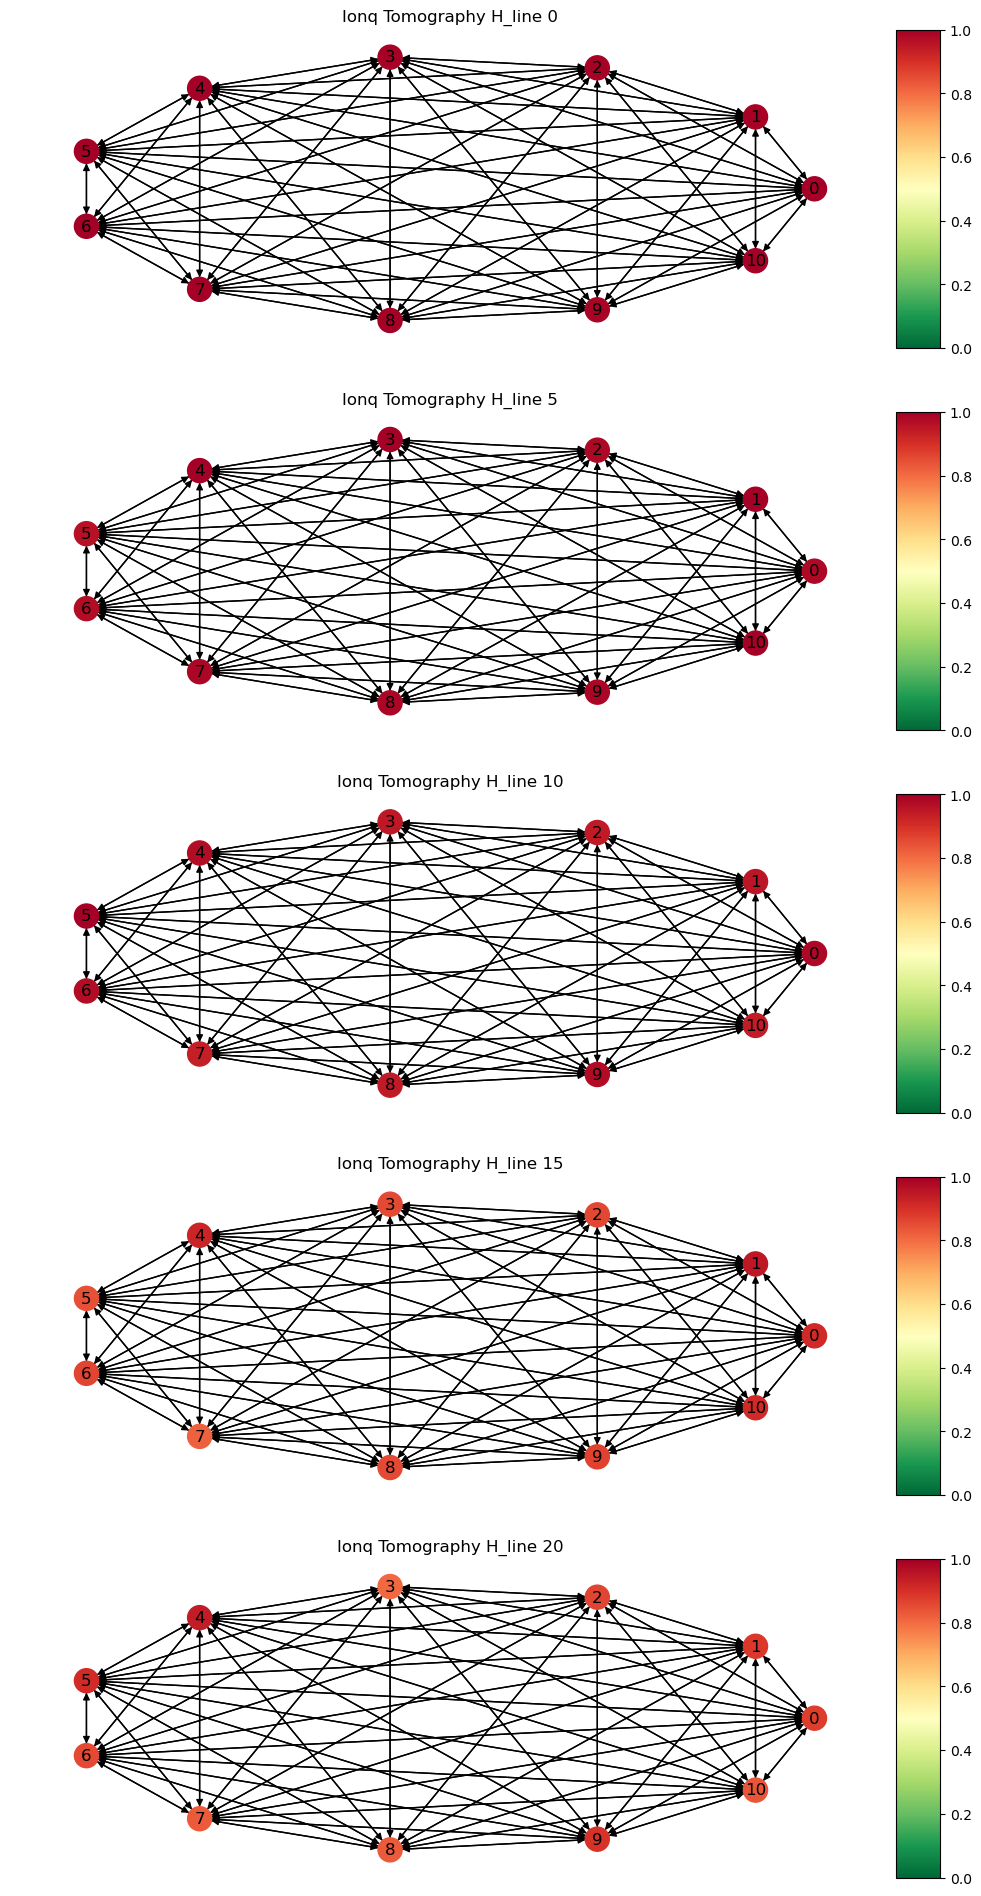

In [35]:
print(purity[0])

fig ,axx = plt.subplots(5,1, figsize = (12,24))

for ax ,p, lab in zip(axx, purity,labels):

    map = dict()
    for x, key in enumerate(p.keys()):
        map[x] = key

    print (map)

    plot_on_device( data = p, device =DeviceUtils.get_device("ionq"),ax = ax, rewiring_map= map)
    ax.set_title(lab)

In [ ]:
#requires mayavi and qutip

#choose the density dataset changing the index [.]
plot_density_eigen(densities=density[5], mayavi = True)

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

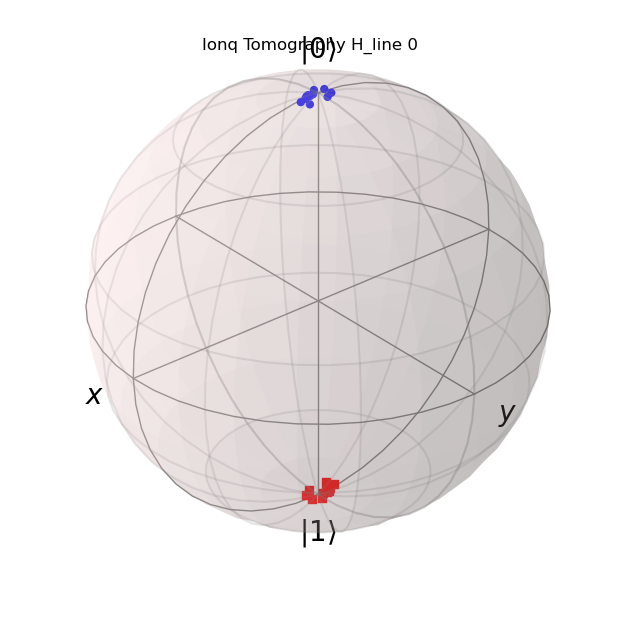

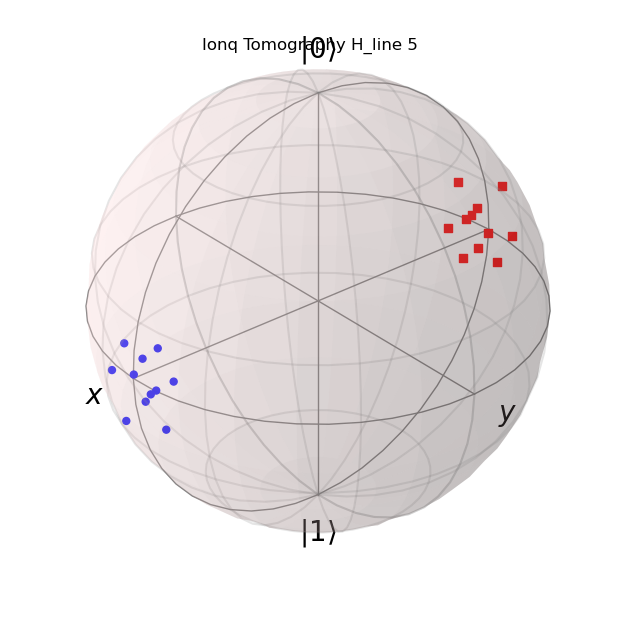

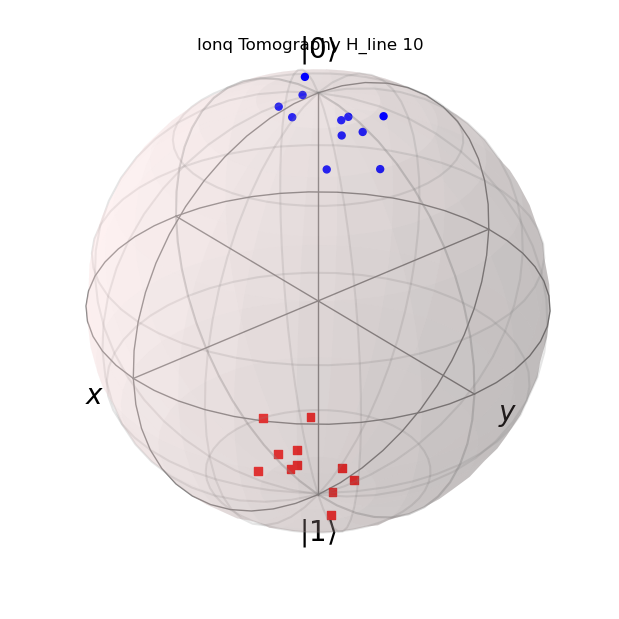

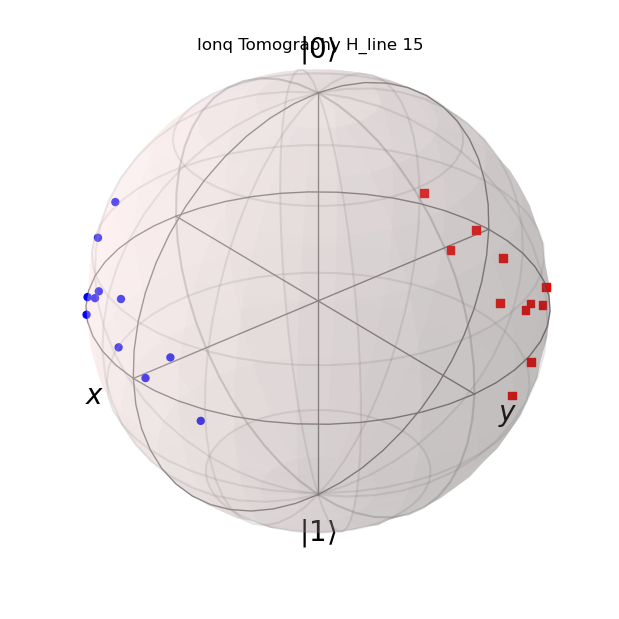

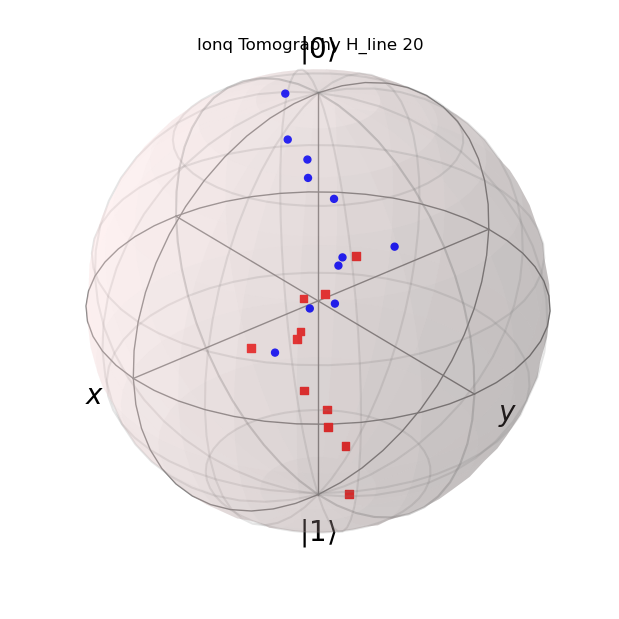

In [36]:
for ax,d, lab in zip(axx, density, labels):

    ax = plot_density_eigen(densities = d, mayavi = False)
    ax.set_title(lab)